# Focusing on the SPIDER leg (middle leg)

_______________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all the python libraries that I wll be using.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the Data Cube

Here, I am downloading the data cube from GHIGLS in a fits format

In [2]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

--2020-07-31 23:25:50--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits
Resolving www.cita.utoronto.ca... 128.100.76.44
Connecting to www.cita.utoronto.ca|128.100.76.44|:443... connected.
ERROR: cannot verify www.cita.utoronto.ca’s certificate, issued by “/C=GB/ST=Greater Manchester/L=Salford/O=Sectigo Limited/CN=Sectigo RSA Organization Validation Secure Server CA”:
  Issued certificate has expired.
To connect to www.cita.utoronto.ca insecurely, use ‘--no-check-certificate’.


Here, I am installing ROHSApy

In [3]:
!pip install ROHSApy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/python/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.


## Load the Data Cube

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_SPIDER_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

Need to adjust the header for the axis to be in velocity rather than pixel units

In [5]:
hdr["NAXIS3"] = 175 # The range of subvel (end_subvel - start_subvel) = (550-350) = 200
hdr["CRPIX3"] -= 350 # This is to fix the position of the peaks to have the right index and velocity (start_subvel)

This is a function that will convert the pixel units axis into a velocity axis in units of km/s

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

In [7]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Using ROHSA to analyze the SPIDER leg

In [8]:
!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
import os
os.chdir('ROHSA/src')
!make
os.chdir('../../')

fatal: destination path 'ROHSA' already exists and is not an empty directory.
gfortran blas.o lbfgsb.o linpack.o timer.o mod_constants.o mod_convert.o mod_inout.o mod_array.o mod_optimize.o mod_optimize_lym.o mod_minimize.o mod_functions.o mod_start.o mod_rohsa.o main.o -lm -g -O2  -o ROHSA


## Define limits and define the region

In [9]:
# Approximate center position of the spider leg is y=130, x=85
# Since we want a square of 64 x 64, we need to go 32 up and 32 down with respect to both x and y
cent_spiderleg_x = 85 ; cent_spiderleg_y = 130


leg_lim = 32
spider_leg_x_left = cent_spiderleg_x-leg_lim ; spider_leg_x_right = cent_spiderleg_x+leg_lim
spider_leg_y_left = cent_spiderleg_y-leg_lim ; spider_leg_y_right = cent_spiderleg_y+leg_lim

idx_lim_left = 350; idx_lim_right = 525

subvel_spiderleg = vel[:idx_lim_right-idx_lim_left]
subcube_spiderleg = cube[idx_lim_left:idx_lim_right, spider_leg_y_left:spider_leg_y_right, spider_leg_x_left:spider_leg_x_right]

I can first try to plot a single spectrum of the center of the leg:

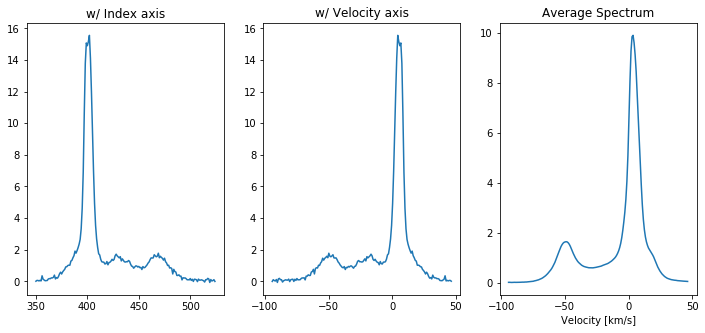

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis")
plt.plot(index_arr[idx_lim_left:idx_lim_right], cube[idx_lim_left:idx_lim_right,cent_spiderleg_y,cent_spiderleg_x])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis")
plt.plot(subvel_spiderleg, cube[idx_lim_left:idx_lim_right,cent_spiderleg_y,cent_spiderleg_x])

plt.subplot(1,3,3)
avg_spideleg = np.mean(subcube_spiderleg, (1,2))
plt.title("Average Spectrum")
plt.plot(subvel_spiderleg, avg_spideleg)
plt.xlabel("Velocity [km/s]")

plt.show()

## Define the ROHSA parameters

In [11]:
filename = "GHIGLS_SPIDER_Tb.dat" #@param
fileout = "GHIGLS_SPIDER_Tb_gauss_run_spiderleg.dat" #@param
filename_parameters = "parameters_spiderleg.txt"
filename_noise = ''
n_gauss = 16          #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 400   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 2.
ub_sig_init = 10.
lb_sig = 2.
ub_sig = 100.

core = ROHSA(subcube_spiderleg, hdr=hdr)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout, 
                    filename_parameters=filename_parameters,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    save_grid=save_grid)

Generate GHIGLS_SPIDER_Tb.dat file readable by fortran
Generate parameters_spiderleg.txt file


In [12]:
# ! ./ROHSA/src/ROHSA parameters_spiderleg.txt

## Get the Gaussian parameters for the decomposition

In [13]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [14]:
gaussian_spiderleg = core.read_gaussian("GHIGLS_SPIDER_Tb_gauss_run_spiderleg.dat")
params = core.physical_gaussian(gaussian_spiderleg)

print("dim cube = " + str(gaussian_spiderleg.shape))

model_spiderleg = core.return_result_cube(gaussian=gaussian_spiderleg)

# Physical Space
amplitude_spiderleg = gaussian_spiderleg[0::3]
position_spiderleg = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_spiderleg[1::3]))
dispersion_spiderleg = gaussian_spiderleg[2::3]

# "Pixel" Space
amplitude_pix = gaussian_spiderleg[0::3]
position_pix = gaussian_spiderleg[1::3]
dispersion_pix = gaussian_spiderleg[2::3]* dv

integral_spiderleg = amplitude_spiderleg * dispersion_spiderleg * np.sqrt(2*np.pi) 

Opening data file
dim cube = (48, 64, 64)


In [15]:
NHI_map_spiderleg = integral_spiderleg * C

I can find the mean positions of the peaks and the dispersions too:

In [16]:
# Can find position of the peaks so that I can identify which peak is which
print(np.median(position_spiderleg, (1,2)))

[  4.17650857 -50.78895398  14.24810656 -38.42901315 -22.62470577
   1.09035225   9.53419525 -57.54758755  37.94864076   6.73083878
  -7.6160276   15.20214255 -81.44910105  -2.16494277 -45.73556141
   3.65167246]


In [17]:
print(np.median(dispersion_spiderleg, (1,2)))

[ 2.04102592  5.00681988 11.85224958  6.16702928  7.25645016  2.0367159
  3.01418     8.95176115 10.40300605  2.04883888  7.75544324  3.71856483
 10.29095284  2.94043756  3.54781606  2.02277641]


## Plot a spectrum

In [18]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    fig = plt.figure(figsize=(8,6))
    plt.xlabel("$v$ [$km$ $s^{-1}$]")
    plt.ylabel("$T_{b}$ [$K$]")
    plt.plot(vel, cube, color='cornflowerblue',  label="data")
    plt.plot(vel, model , color='red', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
            plt.plot(vel, core.gauss(np.arange(len(vel)), \
                                              gaussian[0::3][i][y_pos,x_pos],\
                                              gaussian[1::3][i][y_pos,x_pos],\
                                              gaussian[2::3][i][y_pos,x_pos]), 'k')
    plt.legend()
    plt.show()
    fig.savefig(caption, bbox_inches="tight")

In [19]:
x_pos = random.randint(0,63); y_pos = random.randint(0,63)
print("x = ", x_pos) ; print("y = ", y_pos)

x =  28
y =  53


In [20]:
x_pos = 60 ; y_pos = 45 # This will overlap with the right most legs so we can see the same pixel

#### Plot using matplotlib

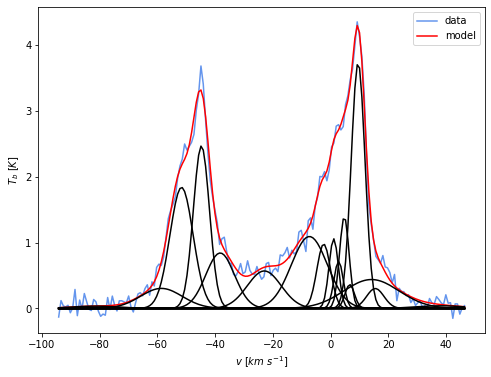

In [21]:
plot_spect(x_pos, y_pos, subvel_spiderleg,\
           model_spiderleg[:, y_pos, x_pos], subcube_spiderleg[:, y_pos, x_pos], gaussian_spiderleg,\
           "random_spectrum.pdf")

## Find the value of $\chi^{2}$ 

In [22]:
stdev_spiderleg = np.std(cube[5:25,0,0])
stdev_spiderleg

0.124584325

In [23]:
subcube_spiderleg = subcube_spiderleg

N_model_subcube_spiderleg = model_spiderleg[:,y_pos,x_pos] # Actual spectrum data
N_data_subcube_spiderleg = subcube_spiderleg[:,y_pos,x_pos] # Gaussian model 

r_subcube_spiderleg = N_data_subcube_spiderleg - N_model_subcube_spiderleg

chisq_spiderleg = np.sum((r_subcube_spiderleg / stdev_spiderleg)**2)
print("The value of chi squared is:", chisq_spiderleg)

The value of chi squared is: 132.00690771092115


## Plot a mosaic of spectra

<Figure size 432x288 with 0 Axes>

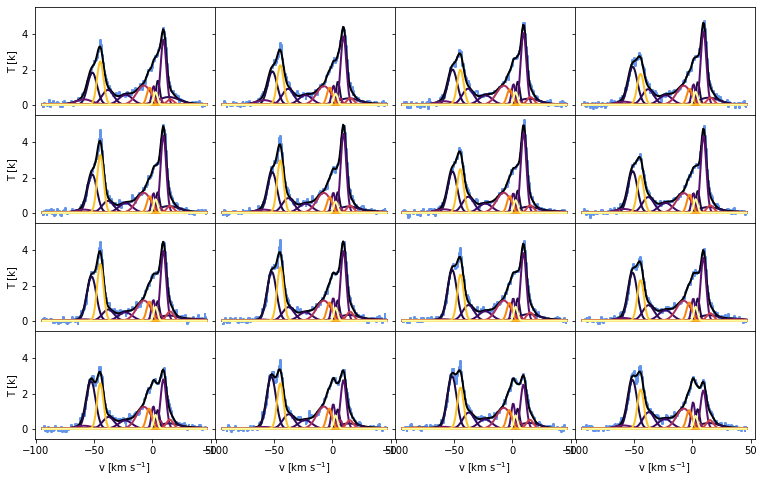

In [24]:
# Mosaic of the Spectra

pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)
fig = plt.figure()
ny = 4; nx = 4
center_y = y_pos; center_x = x_pos
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel_spiderleg, subcube_spiderleg[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(subvel_spiderleg, model_spiderleg[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(subvel_spiderleg, core.gauss(np.arange(len(subvel_spiderleg)), gaussian_spiderleg[0::3][k][center_y+i,center_x+j],
                                              gaussian_spiderleg[1::3][k][center_y+i,center_x+j], gaussian_spiderleg[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.inferno(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
fig.savefig("Mosaic_of_spectra_spiderleg.pdf", bbox_inches="tight")
#plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Plot maps of the LVC and IVC (looking at CNM and WNM)

In [25]:
# find the Gaussians that represent CNM and WNM
CNM_idx = np.where(np.median(dispersion_spiderleg, (1,2)) < 5.)[0].tolist()
WNM_idx = np.where(np.median(dispersion_spiderleg, (1,2)) > 5.)[0].tolist()

# Find the Gaussians that represent the LVC and IVC
LVC_idx = np.where(np.median(position_spiderleg, (1,2)) > -30)[0].tolist()
IVC_idx = np.where(np.median(position_spiderleg, (1,2)) < -30)[0].tolist()

print("CNM idx:",CNM_idx ,"\n"); print("WNM idx:",WNM_idx, "\n")
print("LVC idx:",LVC_idx ,"\n"); print("IVC idx:",IVC_idx)

CNM idx: [0, 5, 6, 9, 11, 13, 14, 15] 

WNM idx: [1, 2, 3, 4, 7, 8, 10, 12] 

LVC idx: [0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 15] 

IVC idx: [1, 3, 7, 12, 14]


In [26]:
model_CNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[CNM_idx],\
                                    pixfield=np.array(position_pix)[CNM_idx], sigfield=np.array(dispersion_pix)[CNM_idx])

model_WNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[WNM_idx], \
                                    pixfield=np.array(position_pix)[WNM_idx], sigfield=np.array(dispersion_pix)[WNM_idx])

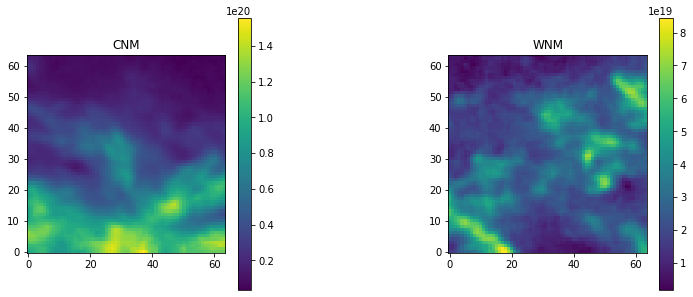

In [27]:
NHI_map_spiderleg_CNM = NHI_map_spiderleg[CNM_idx]
NHI_map_spiderleg_WNM = NHI_map_spiderleg[WNM_idx]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1) ; plt.title("CNM")
plt.imshow(NHI_map_spiderleg_CNM[0], origin="lower")
plt.colorbar()

plt.subplot(1,2,2) ; plt.title("WNM")
plt.imshow(NHI_map_spiderleg_WNM[0], origin="lower")
plt.colorbar()
plt.subplots_adjust(wspace=0.7); plt.show()

#### Summing over all pixels and looking at the gaussians at each pixel

In [28]:
for i in range(subcube_spiderleg.shape[1]):
    for j in range(subcube_spiderleg.shape[2]):
    
        integ_LVC_CNM = np.zeros((subcube_spiderleg.shape[1], subcube_spiderleg.shape[2]))
        integ_LVC_WNM = np.zeros((subcube_spiderleg.shape[1], subcube_spiderleg.shape[2]))
        integ_IVC_CNM = np.zeros((subcube_spiderleg.shape[1], subcube_spiderleg.shape[2]))
        integ_IVC_WNM = np.zeros((subcube_spiderleg.shape[1], subcube_spiderleg.shape[2]))
        
        for n in range(n_gauss):
            # Check the dispersion (sigma) of the gaussian and the position (velocity)
            
            # Check if LVC (velocity cut-off is -30 km/s)
            if position_spiderleg[n][i][j] > -30:
                
                # Check if CNM
                if dispersion_spiderleg[n][i][j] < 5.:
                    integ_LVC_CNM = integ_LVC_CNM + integral_spiderleg[n]
                    
                # Check if WNM
                elif dispersion_spiderleg[n][i][j] > 5.:
                    integ_LVC_WNM = integ_LVC_WNM + integral_spiderleg[n]
                  
                
            # Check if IVC (velocity cut-off is -30 km/s)
            if position_spiderleg[n][i][j] < -30:
                
                # Check if CNM
                if dispersion_spiderleg[n][i][j] < 5.:
                    integ_IVC_CNM = integ_IVC_CNM + integral_spiderleg[n]
                    
                # Check if WNM
                elif dispersion_spiderleg[n][i][j] > 5.:
                    integ_IVC_WNM = integ_IVC_WNM + integral_spiderleg[n]
        

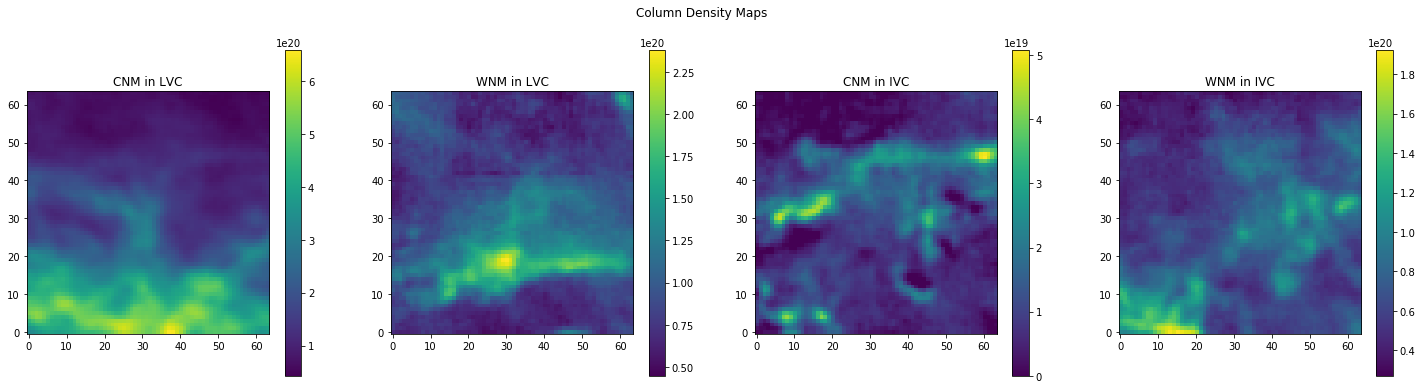

In [29]:
# Can plot the column density maps of each region
fig = plt.figure(figsize=(25,6))

plt.subplot(1,4,1); plt.title("CNM in LVC")
plt.imshow(integ_LVC_CNM * C, origin="lower")
plt.colorbar()

plt.subplot(1,4,2); plt.title("WNM in LVC")
plt.imshow(integ_LVC_WNM * C, origin="lower")
plt.colorbar()

plt.subplot(1,4,3); plt.title("CNM in IVC")
plt.imshow(integ_IVC_CNM* C, origin="lower")
plt.colorbar()

plt.subplot(1,4,4); plt.title("WNM in IVC")
plt.imshow(integ_IVC_WNM * C, origin="lower")
plt.colorbar()

plt.suptitle('Column Density Maps'); plt.subplots_adjust(wspace=0.2); plt.show()

fig.savefig("Plots_of_Phases.pdf", bbox_inches='tight')

## 2D Histogram

In [30]:
iddx = np.argsort(np.mean(position_spiderleg, axis=(1,2)))
field = [NHI_map_spiderleg[idd] for idd in iddx]
vfield = [position_spiderleg[idd] for idd in iddx]
ampfield = [amplitude_spiderleg[idd] for idd in iddx]
sigfield = [dispersion_spiderleg[idd] for idd in iddx]

In [ ]:
#HEATMAP 
x_bins = np.linspace(np.min(params[1::3].ravel()), np.max(params[1::3].ravel()), 1200)
y_bins = np.linspace(0.8,12., 1200)
H, xedges, yedges = np.histogram2d(params[1::3].ravel(), params[2::3].ravel(),
                                   weights=np.sqrt(2.*np.pi)*params[0::3].ravel()*(params[2::3].ravel())*C/1.e18/np.sum(field),
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
ax = fig.add_subplot(111)
ax.set_ylim([0.8, 12.])
ax.set_xlim([np.min(params[1::3].ravel()),np.max(params[1::3].ravel())])
ax.set_xlabel(r'v [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)
fig.savefig("2D_Histogram_heat_map_spiderleg", bbox_inches="tight")
#plt.savefig("plot/" + 'heatmap.png', format='png', bbox_inches='tight', pad_inches=0.02)

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


## Plot mosaics of the maps (column density, velocity, and dispersion)

Column Density maps:

In [ ]:
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)
        
fig = plt.figure()
#Plot mosaic field                                                                                                                                                                                                                                                                                                         
lh = 4; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.01)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
fig.savefig("Column_Density_spiderleg.pdf", bbox_inches="tight")
# plt.axis('off')
#plt.savefig('plot/mosaic_field.pdf', format='pdf')

Velocity maps:

In [ ]:
#Plot mosaic field mean    
fig = plt.figure()
lh = 4; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.01)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
        k += 1
fig.savefig("Velocity_spiderleg.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_vfield.pdf', format='pdf')

Velocity Dispersion maps:

In [ ]:
#Plot mosaic field sigma 
fig = plt.figure()
lh = 4; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.01)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=16.)
        k += 1
fig.savefig("Velocity_Dispersion_spiderleg.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_sigfield.pdf', format='pdf')

## Plot a residual map

In [ ]:
# Find the residual map
fig=plt.figure()
mdl_spiderleg = np.sum(model_spiderleg, 0)
dat_spiderleg = np.sum(subcube_spiderleg, 0)

plt.imshow(mdl_spiderleg - dat_spiderleg, origin="lower")
plt.colorbar()
fig.savefig("Residual_map_spiderleg.pdf", bbox_inches="tight")